In [1]:
import tensorflow_datasets as tfds
from keras.regularizers import l1, l2
import tensorflow as tf
import numpy as np

In [11]:
 
#(train_ds, test_ds) , info= tfds.load(name = "cifar10", split=['train', 'test'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteW70Z46/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteW70Z46/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


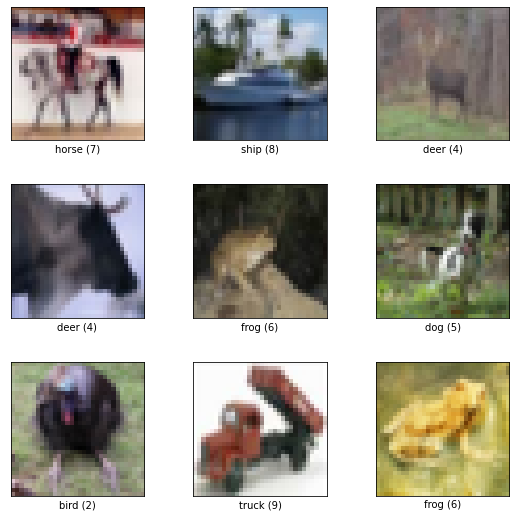

In [2]:

    ## load data
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], 
                             shuffle_files=True, with_info=True)
## visualize sample
#print(ds_info)
tfds.show_examples(train_ds, ds_info)

## preprocessing data 
one_hot = lambda x: tf.one_hot(x, 10)
map_func = lambda x,y: (tf.cast(x, dtype=tf.float32)/255.,
                            tf.cast(one_hot(y),tf.float32))
map_func_2 = lambda x: (x["image"],x["label"])

train_ds = train_ds.map(map_func_2).map(map_func).cache()
val_ds   = val_ds.map(map_func_2).map(map_func).cache()

batch_size = 32
train_ds = train_ds.shuffle(4096).batch(batch_size)
val_ds   = val_ds.shuffle(4096).batch(batch_size)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

 

In [3]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    regularizers = l2(0.01)
    self.conv1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation="relu", kernel_regularizer=regularizers,
    bias_regularizer=regularizers, activity_regularizer=regularizers)
    self.conv2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, activation="relu",kernel_regularizer=regularizers,
    bias_regularizer=regularizers, activity_regularizer=regularizers)
    self.conv3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu",kernel_regularizer=regularizers,
    bias_regularizer=regularizers, activity_regularizer=regularizers)
    self.conv4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation="relu",kernel_regularizer=regularizers,
    bias_regularizer=regularizers, activity_regularizer=regularizers)
    #self.maxpool1 = tf.keras.layers.AvgPooling2D((2,2))
    self.maxpool1 = tf.keras.layers.MaxPool2D((2,2))
    self.dense = tf.keras.layers.Dense(256, activation=tf.nn.relu)
    self.drop = tf.keras.layers.Dropout(0.20)

    self.globalpool = tf.keras.layers.GlobalAveragePooling2D
    self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    #self.batchnorm = tf.keras.

  @tf.function
  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.drop(x)
    x = self.conv2(x)
    x = self.drop(x)
    x = self.maxpool1(x)
    #x = self.maxpool1(x)
    
    x = self.conv3(x)
    x = self.drop(x)
    x = self.conv4(x)
    x = self.drop(x)
    x = self.globalpool()(x)
    #x = self.maxpool2(x)
    #x = self.dense(x)
    x = self.out(x)
    return x
  

In [4]:
def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [5]:
def test(model, test_data, loss_function):
 
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [8]:
tf.keras.backend.clear_session()

num_epochs = 10
learning_rate = 0.001

model = MyModel()
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
  

  #training (and checking in with training)
  epoch_loss_agg = []
  for input,target in train_ds:
    train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
    epoch_loss_agg.append(train_loss)
  
  #track training loss
  train_losses.append(tf.reduce_mean(epoch_loss_agg))

  #testing, so we can track accuracy and test loss
  test_loss, test_accuracy = test(model, val_ds, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print(f'Epoch: {str(epoch)} ending with accuracy {test_accuracies[-1]}')

Epoch: 0 ending with accuracy 0.4145367412140575
Epoch: 1 ending with accuracy 0.48262779552715657
Epoch: 2 ending with accuracy 0.5624001597444089
Epoch: 3 ending with accuracy 0.5855630990415336
Epoch: 4 ending with accuracy 0.6230031948881789
Epoch: 5 ending with accuracy 0.6140175718849841
Epoch: 6 ending with accuracy 0.6442691693290735
Epoch: 7 ending with accuracy 0.6523562300319489
Epoch: 8 ending with accuracy 0.6714257188498403
Epoch: 9 ending with accuracy 0.648861821086262


<Figure size 432x288 with 0 Axes>

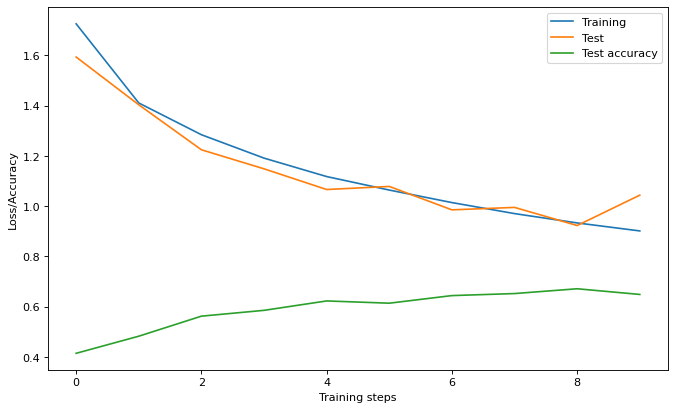

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Visualize accuracy and loss for training and test data.
plt.figure()
figure(figsize=(10, 6), dpi=80)
plt.plot(train_losses)
plt.plot(test_losses)
plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend(["Training","Test", "Test accuracy"])
plt.show()